In [1]:
from biological_fuzzy_logic_networks.DREAM import DREAMBioFuzzNet, DREAMdataset
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hill function to shut of edge

In [2]:
from math import log
class HillTransferFunction(torch.nn.Module):
    """Apply a Hill transformation on 1D input"""

    def __init__(self):
        """
        Initialise the parameters if the transfer functino
        """
        torch.nn.Module.__init__(self)

        self.n = torch.nn.Parameter(1 + torch.normal(mean=log(2), std=0.4, size=(1,)))
        self.K = torch.nn.Parameter(torch.normal(mean=log(0.5), std=0.2, size=(1,)))

    def forward(self, x):
        """
        Tranforms a value through the transfer function
        Args:
            x = value to be transformed
        """
        # Hill function as in Eduati et al. Cancer Research 2017
        # https://doi.org/10.1158/0008-5472.CAN-17-0078
        K = torch.exp(self.K)
        n = torch.exp(self.n)
        x_min = 1 - x
        output = (x_min**n) / (K**n + x_min**n)
        # in the normalized_Hill branch we normalize the outputs
        output = output * (1 + K**n)
        self.output_value = 1 - output
        return self.output_value

In [3]:
hill = HillTransferFunction()

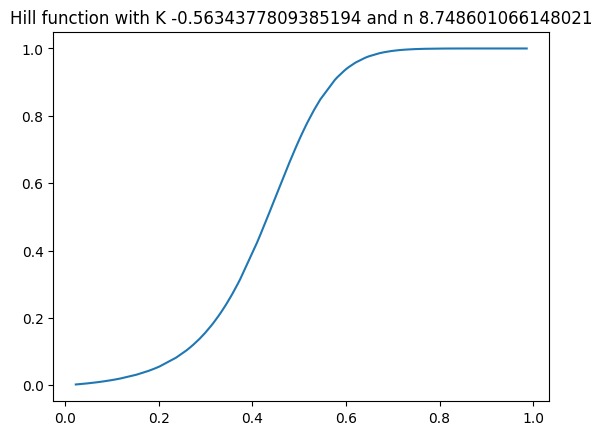

In [4]:
n_samples=1e3
x = torch.rand(100)
with torch.no_grad():
    y = hill(x)
sns.lineplot(x=x, y=y)
t = plt.title(f"Hill function with K {hill.K.detach().numpy()[0]} and n {1+torch.exp(hill.n).detach().numpy()[0]}")

In [5]:
torch.exp(hill.K).detach().numpy()[0] # n and K get exponated before Hill function to ensure positive params

0.5692487437234296

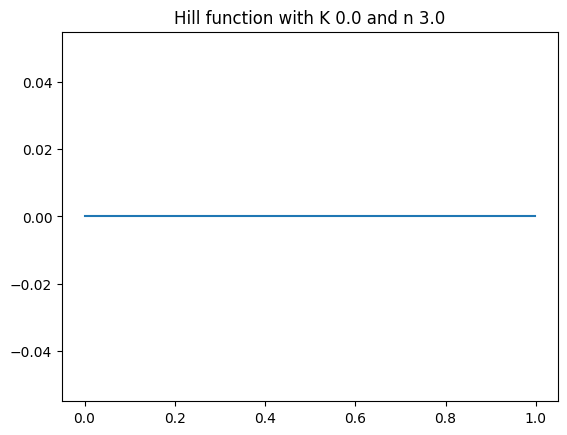

In [7]:
n_samples=1e3
hill.n = torch.nn.Parameter(torch.Tensor([log(2)]))
hill.K = torch.nn.Parameter(torch.Tensor([-1e6]))
x = torch.arange(start=0, end=1., step=1/n_samples)
with torch.no_grad():
    y = hill(x)
    
sns.lineplot(x=x, y=y)
t = plt.title(f"Hill function with K {torch.exp(hill.K).detach().numpy()[0]} and n {1+torch.exp(hill.n).detach().numpy()[0]}")

In [8]:
def hill_func(x, n=3, K=0):
    x_min = 1-x
    output = 1 - ((x_min**n)/(x_min**n + K**n))/(1/(1+K**n))
    
    return output

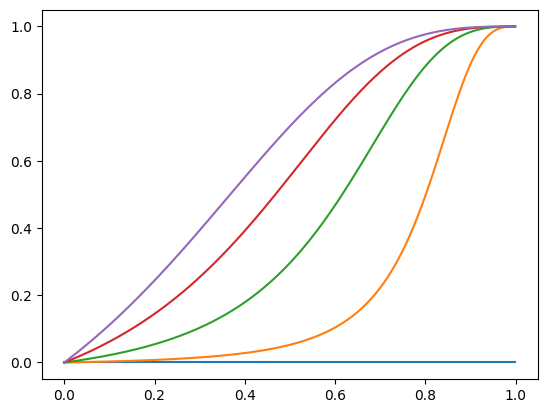

In [9]:
for k in np.arange(start=0, stop=1, step=0.2):
    n=3
    K = k
    x = np.arange(start=0, stop=1., step=1/n_samples)
    y = np.apply_along_axis(hill_func, 0, x, n=n, K=K)

    sns.lineplot(x=x, y=y)
#     t = plt.title(f"Hill function with K {K} and n {n}")

# Networks

In [10]:
teacher_network = DREAMBioFuzzNet.DREAMBioFuzzNet.build_DREAMBioFuzzNet_from_file("/dccstor/ipc1/CAR/BFN/LiverDREAM_PKN.sif")
student_network = DREAMBioFuzzNet.DREAMBioFuzzNet.build_DREAMBioFuzzNet_from_file("/dccstor/ipc1/CAR/BFN/LiverDREAM_PKN.sif")
untrained_network = DREAMBioFuzzNet.DREAMBioFuzzNet.build_DREAMBioFuzzNet_from_file("/dccstor/ipc1/CAR/BFN/LiverDREAM_PKN.sif")

In [11]:
# Generate training data without perturbation
train_size = 10000
teacher_network.initialise_random_truth_and_output(train_size)
inhibition = {k: torch.ones(train_size) for k in teacher_network.nodes}
teacher_network.sequential_update(teacher_network.root_nodes, inhibition=inhibition)
with torch.no_grad():
    true_unperturbed_data = {k:v.numpy() for k,v in teacher_network.output_states.items() if k not in teacher_network.root_nodes}
    input_data = pd.DataFrame({k:v.numpy() for k,v in teacher_network.output_states.items() if k in teacher_network.root_nodes})

train_true_df = pd.DataFrame(true_unperturbed_data)
input_df = pd.DataFrame(input_data)

Text(0.5, 1.0, 'True network, train set no inhibition')

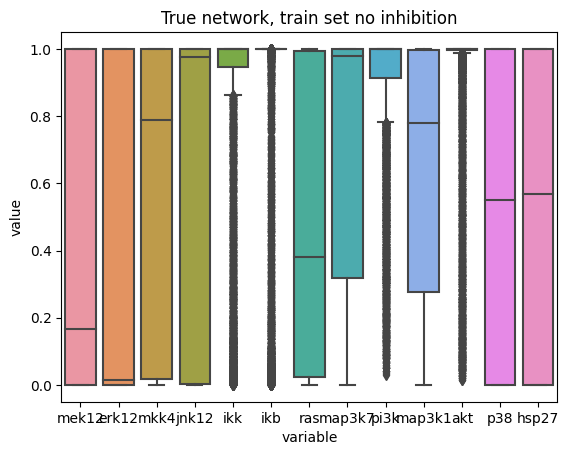

In [12]:
sns.boxplot(train_true_df.melt(), x="variable", y="value")
plt.title("True network, train set no inhibition")

In [13]:
test_size = 1000
teacher_network.initialise_random_truth_and_output(test_size)
inhibition = {k: torch.ones(test_size) for k in teacher_network.nodes}


# Test data without perturbation

In [14]:
# Generate test data with perturbation
teacher_network.sequential_update(teacher_network.root_nodes, inhibition=inhibition)
with torch.no_grad():
    test_data = {k:v for k,v in teacher_network.output_states.items() if k not in teacher_network.root_nodes}
    test_input = {k:v for k,v in teacher_network.output_states.items() if k in teacher_network.root_nodes}

    test_true_df = pd.DataFrame({k: v.numpy() for k, v in test_data.items()})
    test_input_df = pd.DataFrame({k: v.numpy() for k, v in test_input.items()})

Text(0.5, 1.0, 'True network, test set without inhibition')

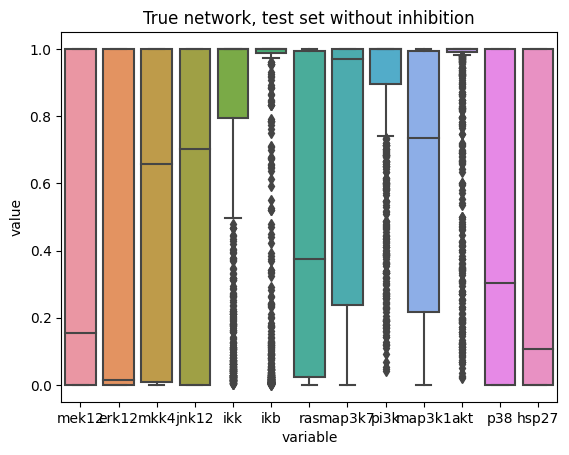

In [15]:
sns.boxplot(test_true_df.melt(), x="variable", y="value")
plt.title("True network, test set without inhibition")

## With perturbation


In [47]:
# Introduce perturbation
original_param = teacher_network.edges[('mek12', 'erk12')]["layer"].K
teacher_network.edges[('mek12', 'erk12')]["layer"].K = torch.nn.Parameter(torch.Tensor([-1e6]))

In [48]:
# Generate test data with perturbation
teacher_network.sequential_update(teacher_network.root_nodes, inhibition=inhibition)
with torch.no_grad():
    perturb_data = {k:v for k,v in teacher_network.output_states.items() if k not in teacher_network.root_nodes}
    perturb_input = {k:v for k,v in teacher_network.output_states.items() if k in teacher_network.root_nodes}

    perturb_true_df = pd.DataFrame({k: v.numpy() for k, v in perturb_data.items()})
    perturb_input_df = pd.DataFrame({k: v.numpy() for k, v in perturb_input.items()})

Text(0.5, 1.0, 'True network, test set inhibition by K=5')

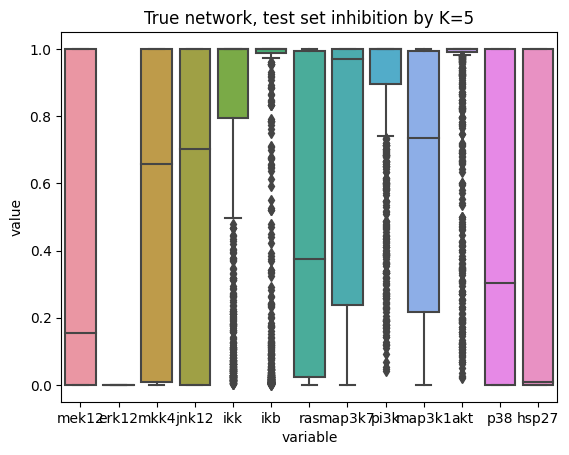

In [49]:
sns.boxplot(perturb_true_df.melt(), x="variable", y="value")
plt.title("True network, test set inhibition by K=5")

# Train student

In [50]:
train = train_true_df.sample(frac=0.7)
val = train_true_df.drop(train.index, axis=0)

train_dict = {c: torch.Tensor(np.array(train[c])) for c in train.columns}
val_dict = {c: torch.Tensor(np.array(val[c])) for c in val.columns} 

# Same input as teacher:
train_input = input_df.iloc[train.index, :]
val_input = input_df.drop(train.index, axis=0)
train_input_dict = {c: torch.Tensor(np.array(train_input[c])) for c in train_input.columns}
val_input_dict = {c: torch.Tensor(np.array(val_input[c])) for c in val_input.columns} 

# Data should have root nodes and non-root nodes
val_dict.update(val_input_dict)
train_dict.update(train_input_dict)

# Inhibitor
train_inhibitors = {c: torch.ones(len(train)) for c in train_dict.keys()}
val_inhibitors = {c: torch.ones(len(val)) for c in val_dict.keys()}



In [51]:
student_network.initialise_random_truth_and_output(train_size)
losses, curr_best_val_loss, _ = student_network.conduct_optimisation(input=train_input_dict, ground_truth=train_dict, train_inhibitors=train_inhibitors,
                                     valid_ground_truth=val_dict, valid_input=val_input_dict, valid_inhibitors=val_inhibitors,
                                    epochs=100, batch_size=500, learning_rate=0.001)

Loss:1.16e-05: 100%|█████████████████████████████████████████████████████████| 100/100 [04:11<00:00,  2.52s/it]


<AxesSubplot:xlabel='time', ylabel='loss'>

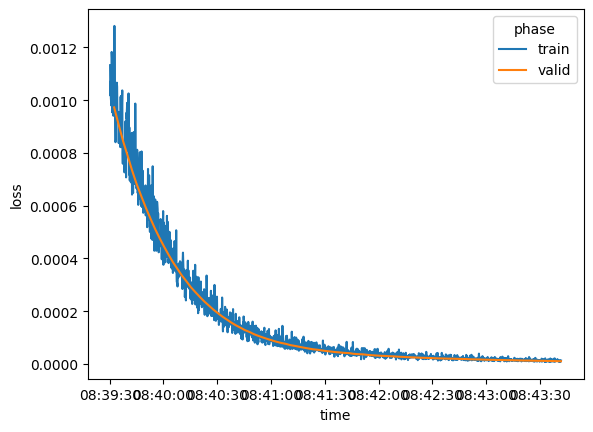

In [52]:
sns.lineplot(losses, x="time", y="loss", hue="phase")

## Test without perturbation

In [53]:
test_ground_truth = test_input.copy()
test_ground_truth.update(test_data)

In [54]:
student_network.initialise_random_truth_and_output(test_size)
student_network.set_network_ground_truth(test_ground_truth)

student_network.sequential_update(teacher_network.root_nodes, inhibition=inhibition)
with torch.no_grad():
    test_output = {k:v for k,v in student_network.output_states.items() if k not in student_network.root_nodes}
    test_output_df = pd.DataFrame({k: v.numpy() for k,v in test_output.items()})

Text(0.5, 1.0, 'Predicted test set without perturbation')

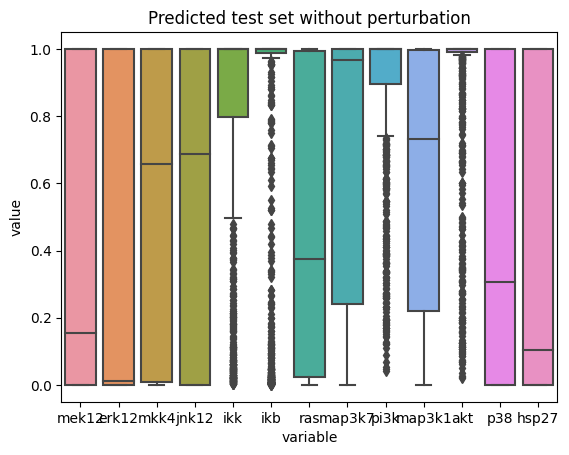

In [55]:
sns.boxplot(test_output_df.melt(), x="variable", y="value")
plt.title("Predicted test set without perturbation")

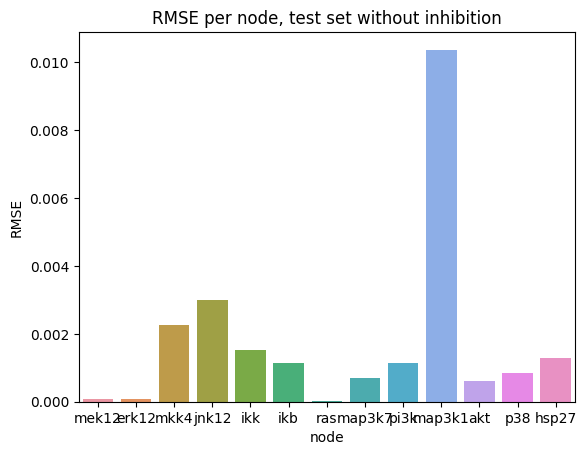

In [56]:
sns.barplot(np.sqrt(((test_output_df - test_true_df)**2).mean()).reset_index(drop=False), x="index", y=0)
t = plt.ylabel("RMSE")
t = plt.xlabel("node")
t = plt.title("RMSE per node, test set without inhibition")

In [57]:
print(original_param, teacher_network.edges[('mek12', 'erk12')]["layer"].n)

Parameter containing:
tensor([-0.8843], requires_grad=True) Parameter containing:
tensor([1.6589], requires_grad=True)


In [58]:
print(student_network.edges[('mek12', 'erk12')]["layer"].K, student_network.edges[('mek12', 'erk12')]["layer"].n)

Parameter containing:
tensor([-0.8839], requires_grad=True) Parameter containing:
tensor([1.6597], requires_grad=True)


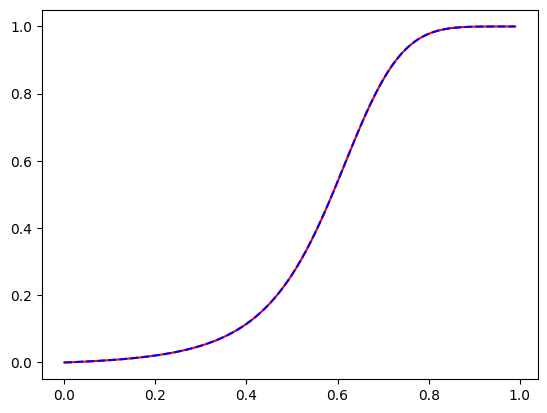

In [59]:
teacher_hill = teacher_network.edges[('mek12', 'erk12')]["layer"]
teacher_hill.K = original_param
student_hill = student_network.edges[('mek12', 'erk12')]["layer"]
x = torch.Tensor([i/100 for i in range(100)])
with torch.no_grad():
    y_teach = teacher_hill(x)
    y_student = student_hill(x)
plt.plot(x, y_teach, c="red", label="teacher")
plt.plot(x, y_student, c="blue", linestyle="dashed", label="student")
# plt.title("Hill function with K=5")

## With perturbation

In [60]:
perturb_inhibition = inhibition.copy()
perturb_inhibition["mek12"] = torch.Tensor([10]*test_size)
perturb_ground_truth = perturb_input.copy()
perturb_ground_truth.update(perturb_data)

In [61]:
student_network.initialise_random_truth_and_output(test_size)
student_network.set_network_ground_truth(perturb_ground_truth)

student_network.sequential_update(teacher_network.root_nodes, inhibition=perturb_inhibition)
with torch.no_grad():
    perturb_output = {k:v for k,v in student_network.output_states.items() if k not in student_network.root_nodes}
    perturb_output_df = pd.DataFrame({k: v.numpy() for k,v in perturb_output.items()})

Text(0.5, 1.0, 'Predicted test set with perturbation by division')

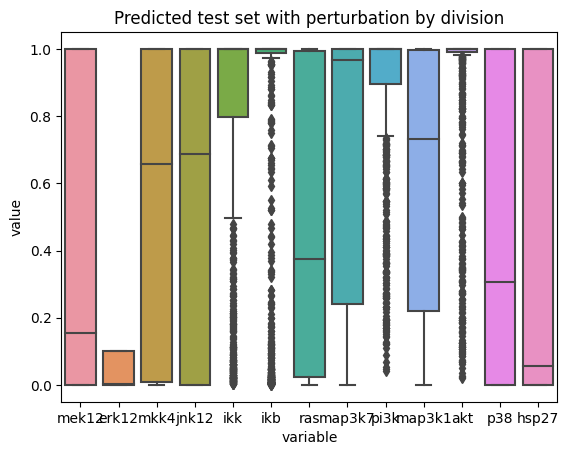

In [62]:
sns.boxplot(perturb_output_df.melt(), x="variable", y="value")
plt.title("Predicted test set with perturbation by division")

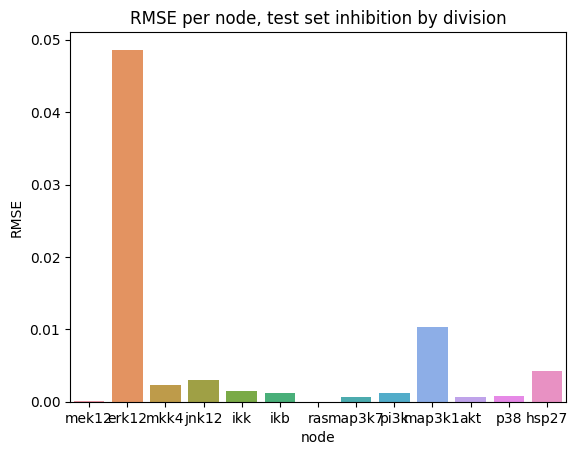

In [63]:
sns.barplot(np.sqrt(((perturb_output_df - perturb_true_df)**2).mean()).reset_index(drop=False), x="index", y=0)
t = plt.ylabel("RMSE")
t = plt.xlabel("node")
t = plt.title("RMSE per node, test set inhibition by division")

# Change back param and add edge inhibition

In [64]:
teacher_network.edges[('mek12', 'erk12')]["layer"].K = original_param

In [65]:
teacher_network.sequential_update(teacher_network.root_nodes, inhibition=perturb_inhibition)
with torch.no_grad():
    true_with_i_data = {k:v.numpy() for k,v in teacher_network.output_states.items() if k not in teacher_network.root_nodes}

Text(0.5, 1.0, 'Same input root nodes, same parameters except inhibited edge')

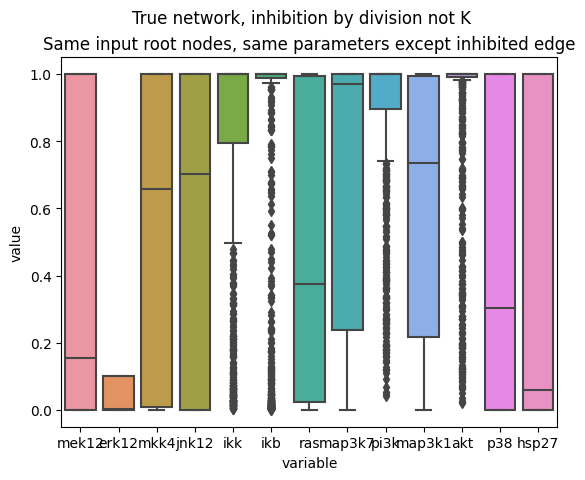

In [66]:
true_with_i_df = pd.DataFrame(true_with_i_data)
sns.boxplot(true_with_i_df.melt(), x="variable", y="value")
plt.suptitle("True network, inhibition by division not K")
plt.title("Same input root nodes, same parameters except inhibited edge")

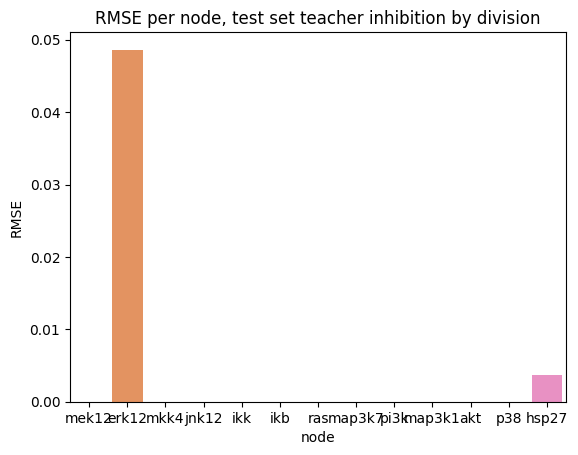

In [67]:
sns.barplot(np.sqrt(((true_with_i_df - perturb_true_df)**2).mean()).reset_index(drop=False), x="index", y=0)
t = plt.ylabel("RMSE")
t = plt.xlabel("node")
t = plt.title("RMSE per node, test set teacher inhibition by division")

# Untrained network with same input as teacher


In [68]:
untrained_network.initialise_random_truth_and_output(test_size)
untrained_network.set_network_ground_truth(test_ground_truth)
untrained_network.sequential_update(teacher_network.root_nodes, inhibition=perturb_inhibition)
with torch.no_grad():
    gen_with_input = {k:v.numpy() for k,v in untrained_network.output_states.items() if k not in untrained_network.root_nodes}

Text(0.5, 1.0, 'Same input root nodes, different parameters')

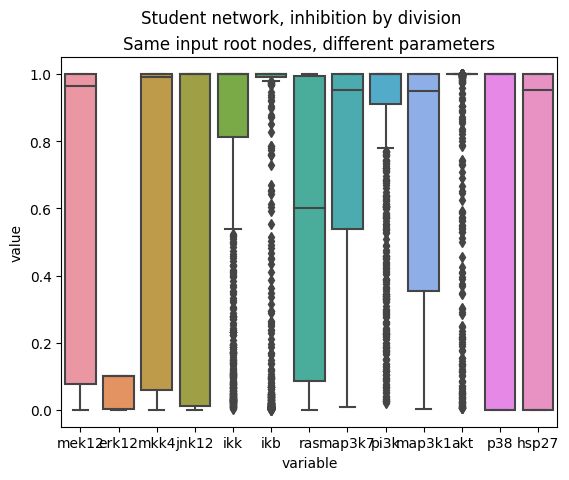

In [69]:
gen_with_input_df = pd.DataFrame(gen_with_input)
sns.boxplot(gen_with_input_df.melt(), x="variable", y="value")
plt.suptitle("Student network, inhibition by division")
plt.title("Same input root nodes, different parameters")

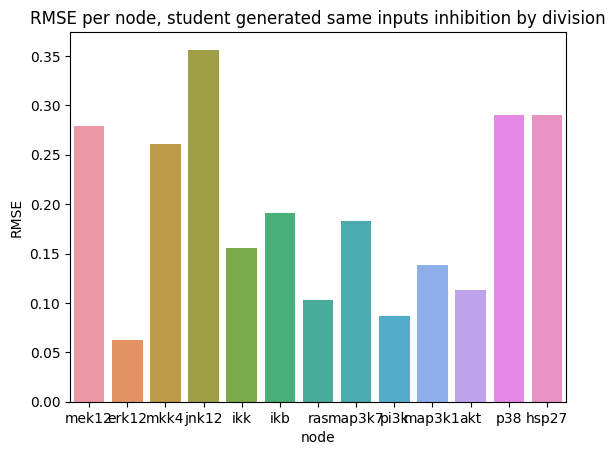

In [70]:
sns.barplot(np.sqrt(((gen_with_input_df - perturb_true_df)**2).mean()).reset_index(drop=False), x="index", y=0)
t = plt.ylabel("RMSE")
t = plt.xlabel("node")
t = plt.title("RMSE per node, student generated same inputs inhibition by division")

# Student network with random initialisation

In [71]:
untrained_network.initialise_random_truth_and_output(test_size)

In [72]:
untrained_network.sequential_update(untrained_network.root_nodes, inhibition=perturb_inhibition)
with torch.no_grad():
    gen = {k:v.numpy() for k,v in untrained_network.output_states.items() if k not in untrained_network.root_nodes}

In [73]:
gen_df = pd.DataFrame(gen)

Text(0.5, 1.0, 'Random input root nodes, different parameters')

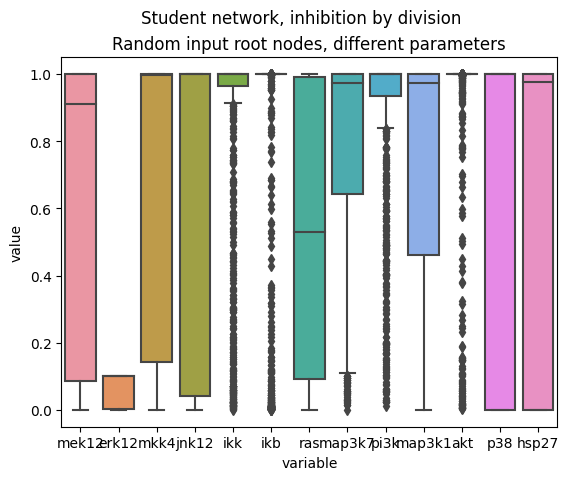

In [74]:
sns.boxplot(gen_df.melt(), x="variable", y="value")
plt.suptitle("Student network, inhibition by division")
plt.title("Random input root nodes, different parameters")

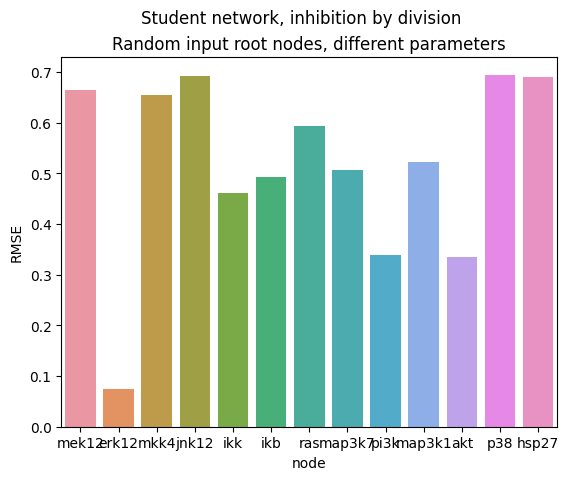

In [75]:
sns.barplot(np.sqrt(((gen_df - perturb_true_df)**2).mean()).reset_index(drop=False), x="index", y=0)
t = plt.ylabel("RMSE")
t = plt.xlabel("node")
t = plt.suptitle("Student network, inhibition by division")
t = plt.title("Random input root nodes, different parameters")

# Compare results

In [76]:
pl_data = pd.concat([true_with_i_df, perturb_output_df, gen_with_input_df, gen_df], 
          keys=["inhibtion changed", "trained and inputs", "untrained and inputs", "untrained no inputs"],
         names = ["Mode", ]).reset_index("Mode", drop=False)
pl_data = pl_data.groupby("Mode").apply(lambda x: np.sqrt(((x-perturb_true_df)**2).mean())).drop("Mode", axis=1)
pl_data = pl_data.reset_index("Mode")
pl_data = pl_data.melt(id_vars="Mode", value_name="RMSE", var_name="Node" )

<AxesSubplot:xlabel='Node', ylabel='RMSE'>

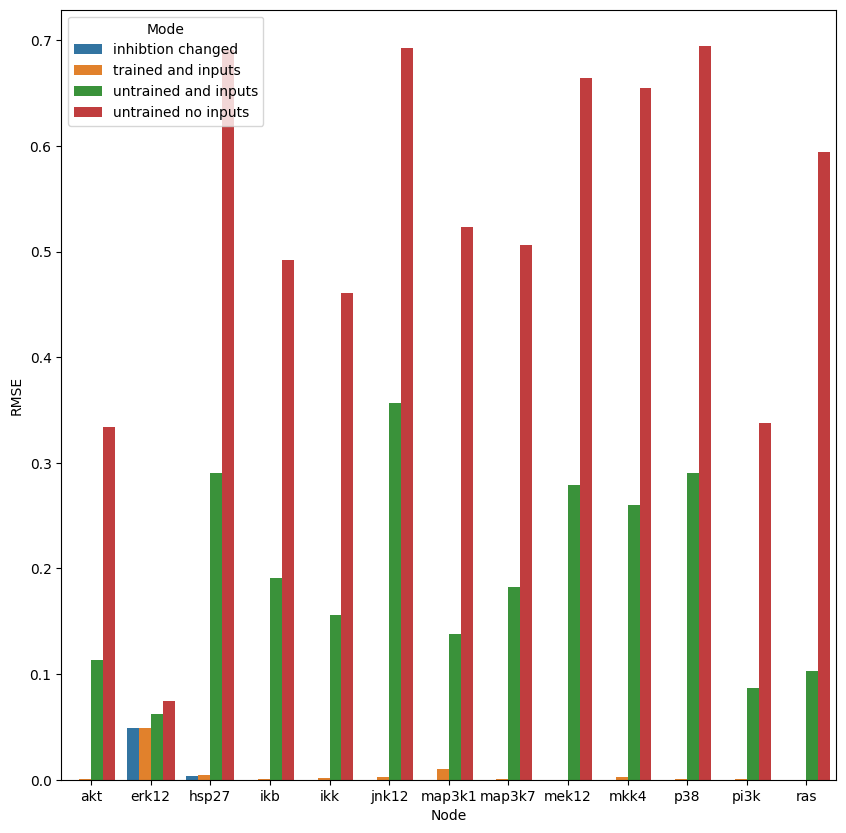

In [77]:
plt.figure(figsize=(10,10))
sns.barplot(data=pl_data, x="Node", y="RMSE", hue="Mode")